In [1]:
# ---------- Imports ----------
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp

plt.rcParams['figure.figsize'] = [20, 12]

In [2]:
# -------------------------------------
# ---------- Bounded Voronoi ----------
# -------------------------------------
# Code from: https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells

# ---------- Functions ----------
def in_box(towers, bounding_box):
    # Returns a new np.array of towers that within the bounding_box
    # bounding_box = [x_min, x_max, y_min, y_max]
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def bounded_voronoi(towers, bounding_box):
    # Generates a bounded vornoi diagram with finite regions
    # bounding_box = [x_min, x_max, y_min, y_max]

    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)

    # Mirror points left, right, above, and under to force finite regions
    points_center = towers[i, :]

    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])

    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])

    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])

    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])

    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)

    # Compute Voronoi
    vor = sp.Voronoi(points)

    # creates a new attibute for points that form the diagram within the region
    vor.filtered_points = points_center
    # grabs the first fifth of the regions, which are the original regions
    vor.filtered_regions = np.array(vor.regions, dtype=object)[vor.point_region[:vor.npoints//5]]
    
    return vor

# Finds the centroid of a region. First and last point should be the same.
def centroid_region(vertices):
    # Polygon's signed area
    A = 0
    # Centroid's x
    C_x = 0
    # Centroid's y
    C_y = 0
    for i in range(0, len(vertices) - 1):
        s = (vertices[i, 0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        A = A + s
        C_x = C_x + (vertices[i, 0] + vertices[i + 1, 0]) * s
        C_y = C_y + (vertices[i, 1] + vertices[i + 1, 1]) * s
    A = 0.5 * A
    C_x = (1.0 / (6.0 * A)) * C_x
    C_y = (1.0 / (6.0 * A)) * C_y
    return np.array([[C_x, C_y]])


# Performs x iterations of loyd's algorithm to calculate a centroidal vornoi diagram
def generate_CVD(points, iterations, bounding_box):
    p = np.copy(points)

    for i in range(iterations):
        vor = bounded_voronoi(p, bounding_box)
        centroids = []

        for region in vor.filtered_regions:
            vertices = vor.vertices[region + [region[0]], :] # grabs vertices for the region and adds a duplicate of the first one to the end
            centroid = centroid_region(vertices)
            centroids.append(list(centroid[0, :]))

        p = np.array(centroids)

    return bounded_voronoi(p, bounding_box)


def plot_vornoi_diagram(fig, vor, bounding_box, plotInitPts = False, plotRidgePts = True, plotRidge = True):
    # Plots voronoi data (vor) onto pyplot (fig)
    # bounding_box = [x_min, x_max, y_min, y_max]
    ax = fig.gca()

    # Plot initial points
    if plotInitPts:
        ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], '+r', label = 'Gauss Centres')
        for i, pnt in enumerate(vor.filtered_points):
            ax.annotate("  " + str(i), (pnt))

    # Plot ridges points
    if plotRidgePts:
        first = True
        for region in vor.filtered_regions:
            vertices = vor.vertices[region, :]
            ax.plot(vertices[:, 0], vertices[:, 1], 'go', label = 'Ridges Points' if first else '')
            first = False

    # Plot ridges
    if plotRidge:
        first = True
        for region in vor.filtered_regions:
            vertices = vor.vertices[region + [region[0]], :]
            ax.plot(vertices[:, 0], vertices[:, 1], 'k-', label = 'Ridges' if first else '')
            first = False

    # Tidy details 
    margin_percent = .1
    width = bounding_box[1]-bounding_box[0]
    height = bounding_box[3]-bounding_box[2]

    ax.set_xlim([bounding_box[0]-width*margin_percent, bounding_box[1]+width*margin_percent])
    ax.set_ylim([bounding_box[2]-height*margin_percent, bounding_box[3]+height*margin_percent])
    ax.legend()

    return fig

In [3]:
# np.random.seed(1)
# n_towers = 100
# towers = np.random.rand(n_towers, 2)
# bounding_box = np.array([0., 1., 0., 1.]) # [x_min, x_max, y_min, y_max]

# for i in range(0, 9): 
#     vor = generate_CVD(towers, i, bounding_box)
#     fig = plt.figure()
#     fig = plot_vornoi_diagram(fig, vor, bounding_box, True)

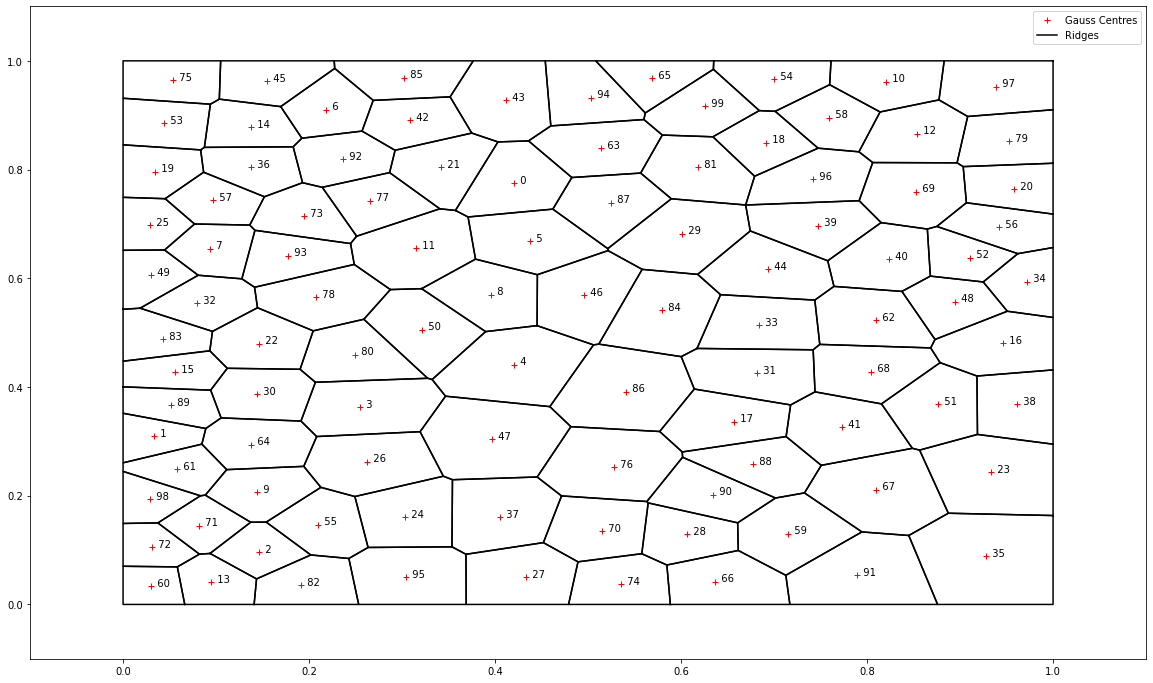

In [4]:
np.random.seed(1)
n_towers = 100
towers = np.random.rand(n_towers, 2)
bounding_box = np.array([0., 1., 0., 1.]) # [x_min, x_max, y_min, y_max]

vor = generate_CVD(towers, 3, bounding_box)
fig = plt.figure()
fig = plot_vornoi_diagram(fig, vor, bounding_box, True, False)